# GIZ NLP Agricultural Keyword Spotter

File name: GIZNLP_Preprocessing.ipynb

Author: kogni7

Date: October/November 2020

## Contents
* 1. Preparation
  * 1.1 Libraries and Seed
  * 1.2 Variables
* 2 Data
  * 2.1 Load CSV data
  * 2.2 Prepare the data
    * Function for wav converting
    * Copy wavs to new directories
    * Clean the sample submission data frame
    * Descriptive Statistics
    * Check that data is mono
    * Play some samples
  * 2.3 Show some spectrograms
  * 2.4 Build spectrograms
  * 2.5 Preprocess the data
  * 2.6 Save the preprocessed data

The file system for this project is:

- GIZNLP (root)
  - GIZNLP_Preprocessing.ipynb (this notebook)
  - GIZNLP_Modelling.ipynb
  - Data
      - audio_files
      - latest_keywords
      - nlp_keywords
      - Train.csv
      - SampleSubmission.csv
  - Preprocessed_Data (will be created during the run of this notebook)
  - Submission
      - 1 - x: Submission directories, named by the version number
          - checkpoint_model.h5 (saved keras model)
          - model.h5 (saved keras model)
          - submission.csv

This jupyter notebook runs in Google Colab without special configuration (and with the automatically loaded packages). GPU and TPU are disabled.

## 1. Preparation
### 1.1 Libraries and Seed

In [1]:
SEED = 42

# Math
import numpy as np

# Seeds
import random
import os
os.environ['PYTHONHASHSEED'] = str(SEED)

np.random.seed(SEED + 1)
random.seed(SEED + 2)

# Working with CSV
import pandas as pd

# Signal processing
from scipy import signal
from scipy.io import wavfile

# Further imports
import shutil
import IPython.display as ipd
import time
from tqdm import tqdm
import pickle

# Plotting
import matplotlib.pyplot as plt

# Machine Learning
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import StratifiedKFold

### 1.2 Variables

In [2]:
# Time 
start_time = time.time()

# for use in Google Colab
from google.colab import drive
drive.mount('/content/drive')

# Working Directory
WD = os.getcwd() + "/drive/My Drive/Colab Notebooks/GIZNLP"
print(WD)

# Paths
path_train_wavs = WD + '/Preprocessed_Data/train_wavs'
path_test_wavs = WD + '/Preprocessed_Data/test_wavs'

os.mkdir(WD + '/Preprocessed_Data')
os.mkdir(path_train_wavs)
os.mkdir(path_test_wavs)

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/GIZNLP


## 2 Data
### 2.1 Load CSV data

In [3]:
train = pd.read_csv(WD + '/Data/Train.csv')
sample_submission = pd.read_csv(WD + '/Data/SampleSubmission.csv')

In [4]:
train.head()

,fn,label
0,audio_files/IV38R7F.wav,akawuka
1,audio_files/KM4SKWT.wav,banana
2,audio_files/F5POSU9.wav,obulwadde
3,audio_files/MMVDXG2.wav,nnyaanya
4,audio_files/9TVM96F.wav,pampu


In [5]:
sample_submission.head()

,fn,maize streak virus,disease,okukkoola,muwogo,mpeke,mucungwa,greens,garden,mango,bulimi,obuwuka,ebikoola,obulimi,ebisoolisooli,kaamulali,eddagala,beans,omuyembe,leaf,kisaanyi,leaves,butterfly,okuzifuuyira,micungwa,ppaapaali,emboga,kikolo,harvest,olusuku,coffee,super grow,rice,ensujju,okulima,worm,ebbugga,onion,ensigo,plantation,...,ejjobyo,omulimi,okusimba,sweet potatoes,okufuuyira,farming instructor,nnasale beedi,passion fruit,ekitooke,ebisaanyi,ekyeya,enva endiirwa,emisiri,emiyembe,amatooke,ebiwuka,farm,ebinyebwa,amappapaali,ebimera,kassooli,harvesting,emmwanyi,akamonde,obumonde,cabbages,akasaanyi,spread,ebirime,drought,kasaanyi,suckers,insects,fertilizer,nakavundira,ekiwojjolo,akawuka,ddagala,ebiwojjolo,obutungulu
0,audio_files/00118N3.wav,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,audio_files/00P0NMV.wav,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,audio_files/01QEEZI.wav,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,audio_files/037YAED.wav,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,audio_files/0382N0Y.wav,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### 2.2 Prepare the data
#### Function for wav converting

In [6]:
"""
The code of this cell (a function for webm to wav converting) is from https://gist.github.com/pmwaniki/fece16fff8f53ddb33d13df51054ab02.
"""

"""
Convert a file from .webm to .wav using the ffmpeg utility. Tested on linux.
install ffmpeg: apt install ffmpeg
Params:
    file: filename to be converted
    old_dir: path to file that is to be converted
    new_dir: directory to save the result.
    
Example:
convert_webm_to_wav("5aa4893526794a73a3ed0a7ebba2a7bf_4a86cf2df5bd486c843637ce780d47d7.wav","latest_keywords/kukungula","latest_keywords2/kukungula")
Make sure the directories exist.
"""

import subprocess
import os

def convert_webm_to_wav(file,old_dir,new_dir):
    #ffmpeg -i ./big-buck-bunny_trailer.webm -c:a pcm_f32le ./out.wav
    command = ['ffmpeg', '-i', os.path.join(old_dir,file), '-acodec', 'pcm_s16le', '-ac', '1', '-ar', '22050', os.path.join(new_dir,file)]
    subprocess.run(command,stdout=subprocess.PIPE,stdin=subprocess.PIPE)

#### Copy wavs to new directories

In [7]:
# get the training wavs
row = 0
for wav in tqdm(train['fn']):
    # move file   
    shutil.copy(WD + '/Data/' + str(wav), path_train_wavs)
    # change name in fn
    train.loc[row, 'fn'] = wav[12:]
    row += 1

100%|██████████| 1109/1109 [14:01<00:00,  1.32it/s]


In [8]:
# get additional training wavs
# (latest_keywords)
for directory in tqdm(os.listdir(WD + '/Data/latest_keywords')):
    for wav in os.listdir(WD + '/Data/latest_keywords/' + directory):
        # convert and move file
        convert_webm_to_wav(wav, WD + '/Data/latest_keywords/' + directory + '/', path_train_wavs)
        # add wav in train
        train = train.append({'fn': wav, 'label': directory}, ignore_index=True)

100%|██████████| 129/129 [19:05<00:00,  8.88s/it]


In [9]:
# (nlp_keywords)
for directory in tqdm(os.listdir(WD + '/Data/nlp_keywords')):
    if directory != '.DS_Store':
        for wav in os.listdir(WD + '/Data/nlp_keywords/' + directory):
            # convert and move file
            convert_webm_to_wav(wav, WD + '/Data/nlp_keywords/' + directory + '/', path_train_wavs)
            # add wav in train
            train = train.append({'fn': wav, 'label': directory}, ignore_index=True)

100%|██████████| 123/123 [24:01<00:00, 11.72s/it]


In [10]:
# get the testing wavs
for wav in tqdm(sample_submission['fn']):
    shutil.copy(WD + '/Data/' + str(wav), path_test_wavs)

100%|██████████| 1017/1017 [12:42<00:00,  1.33it/s]


In [11]:
train

,fn,label
0,IV38R7F.wav,akawuka
1,KM4SKWT.wav,banana
2,F5POSU9.wav,obulwadde
3,MMVDXG2.wav,nnyaanya
4,9TVM96F.wav,pampu
...,...,...
4704,6fbfcce2cf21419e97290f9e12934f65_6fadfc19ae3d4...,omuyembe
4705,6fbfcce2cf21419e97290f9e12934f65_a6e2d39fb7b74...,omuyembe
4706,d027264654b94950aeb204f64d05d8d7_69445a2266f64...,omuyembe
4707,d027264654b94950aeb204f64d05d8d7_468584423bfe4...,omuyembe


#### Clean the sample submission data frame

In [12]:
row = 0
for wav in sample_submission['fn']:
    # change name in fn
    sample_submission.loc[row, 'fn'] = wav[12:]
    row += 1

sample_submission

,fn,maize streak virus,disease,okukkoola,muwogo,mpeke,mucungwa,greens,garden,mango,bulimi,obuwuka,ebikoola,obulimi,ebisoolisooli,kaamulali,eddagala,beans,omuyembe,leaf,kisaanyi,leaves,butterfly,okuzifuuyira,micungwa,ppaapaali,emboga,kikolo,harvest,olusuku,coffee,super grow,rice,ensujju,okulima,worm,ebbugga,onion,ensigo,plantation,...,ejjobyo,omulimi,okusimba,sweet potatoes,okufuuyira,farming instructor,nnasale beedi,passion fruit,ekitooke,ebisaanyi,ekyeya,enva endiirwa,emisiri,emiyembe,amatooke,ebiwuka,farm,ebinyebwa,amappapaali,ebimera,kassooli,harvesting,emmwanyi,akamonde,obumonde,cabbages,akasaanyi,spread,ebirime,drought,kasaanyi,suckers,insects,fertilizer,nakavundira,ekiwojjolo,akawuka,ddagala,ebiwojjolo,obutungulu
0,00118N3.wav,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,00P0NMV.wav,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,01QEEZI.wav,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,037YAED.wav,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0382N0Y.wav,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1012,ZP9ERJN.wav,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1013,ZPD6KI1.wav,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1014,ZSC69U3.wav,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1015,ZU1I8MR.wav,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Descriptive Statistics

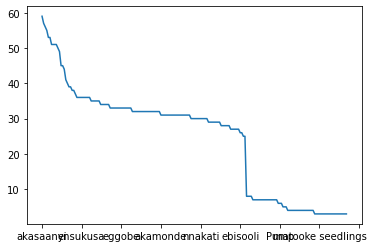

In [13]:
train['label'].value_counts().plot()

We see that the number of samples per word differ. For Luganda words are more samples than for English words, of course.

#### Check that data is mono

In [14]:
number_training_samples = 0
for wav in os.listdir(path_train_wavs):
    _, sig = wavfile.read(path_train_wavs + '/' + wav)
    if len(sig.shape) != 1:
        print(sig.shape)
    number_training_samples += 1

number_testing_samples = 0
for wav in os.listdir(path_test_wavs):
    _, sig = wavfile.read(path_test_wavs + '/' + wav)
    if len(sig.shape) != 1:
        print(sig.shape)
    number_testing_samples += 1

print("All mono.")

All mono.


#### Play some samples

In [15]:
ipd.Audio(path_train_wavs + '/' + train.fn.sample().values[0])

### 2.3 Show some spectrograms
We build spectrograms from the wav-files. A spectrogram shows the signal over time as an image with a time and frequency axis. These images will be used later in the deep learning model.

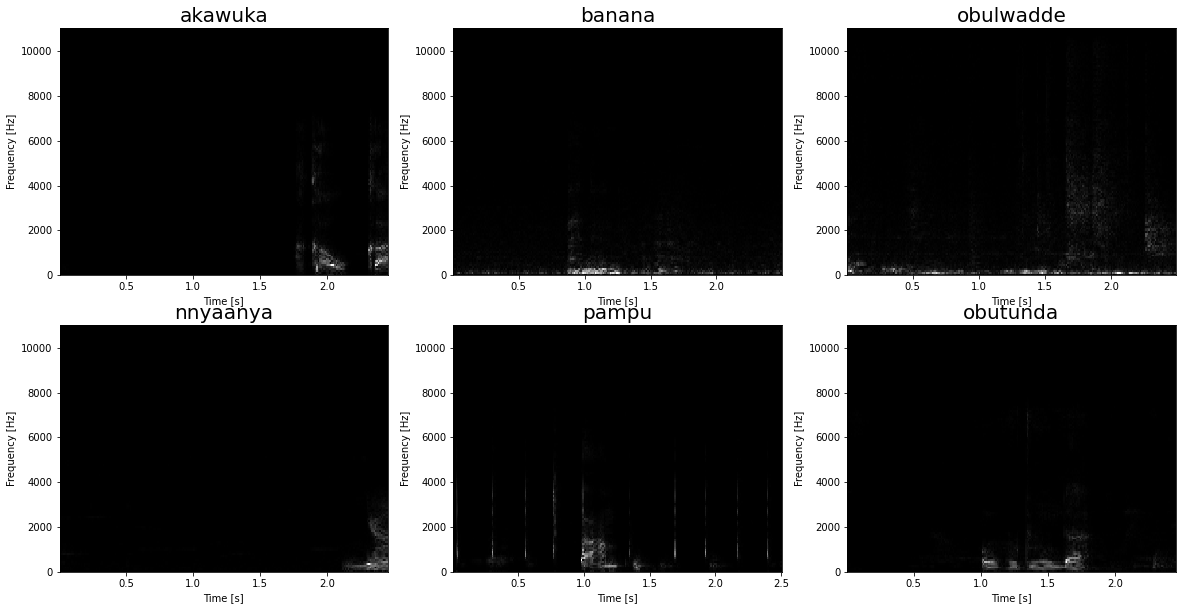

In [16]:
times_list = []
frequencies_list = []
spectrogram_list = []

for wav in train.loc[:6, 'fn']:
    # load wav file
    sample_rate, samples = wavfile.read(path_train_wavs + '/' + wav)
    # build spectrogram
    frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate,
                                                         window=('tukey', 0.25),
                                                         nperseg=None,
                                                         noverlap=None,
                                                         nfft=None,
                                                         detrend='constant',
                                                         return_onesided=True,
                                                         scaling='spectrum',
                                                         axis=-1,
                                                         mode='magnitude')

    times_list.append(times)
    frequencies_list.append(frequencies)
    spectrogram_list.append(spectrogram)

fig, axs = plt.subplots(2, 3, figsize=(20, 10))
for i in range(3):
    axs[0, i].set_title(train.loc[i, 'label'], fontsize=20)
    axs[0, i].pcolormesh(times_list[i], frequencies_list[i], spectrogram_list[i], cmap='gray', shading='auto')
    axs[0, i].set(xlabel='Time [s]', ylabel='Frequency [Hz]')

for i in range(3):
    axs[1, i].set_title(train.loc[i+3, 'label'], fontsize=20)
    axs[1, i].pcolormesh(times_list[i+3], frequencies_list[i+3], spectrogram_list[i+3], cmap='gray', shading='auto')
    axs[1, i].set(xlabel='Time [s]', ylabel='Frequency [Hz]')

plt.show()

### 2.4 Build spectrograms

In [17]:
def build_spectrograms(data, indices, mode):
    """
    This function builds the spectrograms. The samples are identified by the indices.
    
    Usage:
    # Training
    X = build_spectrograms(train, indices, "TRAIN")
    # Validation
    X_val = build_spectrograms(train, indices_val, "VALIDATION")
    # Test
    X_test = build_spectrograms(sample_submission, None, "TEST")
    """

    if mode == "TRAIN" or mode == "VALIDATION":
        spectrograms = []

        for wav in tqdm(data.loc[indices, 'fn']):
            # load wav file
            sample_rate, samples = wavfile.read(path_train_wavs + '/' + wav)

            # build spectrogram
            _, _, spectrogram = signal.spectrogram(samples, sample_rate,
                                                   window=('tukey', 0.25),
                                                   nperseg=None,
                                                   noverlap=None,
                                                   nfft=None,
                                                   detrend='constant',
                                                   return_onesided=True,
                                                   scaling='spectrum',
                                                   axis=-1,
                                                   mode='magnitude')
            spectrograms.append(spectrogram)

    if mode == "TEST":
        spectrograms = []

        for wav in tqdm(data['fn']):
            # load wav file
            sample_rate, samples = wavfile.read(path_test_wavs + '/' + wav)

            # build spectrogram
            _, _, spectrogram = signal.spectrogram(samples, sample_rate,
                                                   window=('tukey', 0.25),
                                                   nperseg=None,
                                                   noverlap=None,
                                                   nfft=None,
                                                   detrend='constant',
                                                   return_onesided=True,
                                                   scaling='spectrum',
                                                   axis=-1,
                                                   mode='magnitude')

            spectrograms.append(spectrogram)

    # pad with 0s
    maximum_0 = 0
    maximum_1 = 0

    for s in spectrograms:
        if maximum_0 < s.shape[0]:
            maximum_0 = s.shape[0]
        if maximum_1 < s.shape[1]:
            maximum_1 = s.shape[1]
        
    padded_spectrograms = []
    
    for s in spectrograms:
        padded_spectrograms.append(np.pad(s, ((0, maximum_0 - s.shape[0]),
                                              (0, maximum_1 - s.shape[1])), 'constant'))

    # Rescaling (min-max normalization ([0,1]): x' = (x - min(x)) / (max(x) - min(x)))
    # https://en.wikipedia.org/wiki/Feature_scaling
    scaled_spectrograms = []
    for s in padded_spectrograms:
        scaled_spectrograms.append((s - s.min()) / (s.max() - s.min()))

    return np.array(scaled_spectrograms)

## 2.5 Preprocess the data

In [18]:
"""
The data sets will be generated. These are the training sets X and y, the validation sets X_val and y_val and the test set X_test.
The validation set is 20% of the original labeled training data. The validation set is stratified for the most labels.
"""

# Label encoding of the data frame
label_encoder = LabelEncoder()
label_encoded = label_encoder.fit_transform(train['label'])

# Generate stratified validation set; get the indices for the sets
place_holder = np.zeros(len(label_encoded))

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)  # i.e. 20% of data for validation, ignore the warning!!!

train_indices = []
val_indices = []

for trainindex, testindex in skf.split(place_holder, label_encoded):
    train_indices.append(trainindex)
    val_indices.append(testindex)

# Build X
X = build_spectrograms(train, train_indices[0], "TRAIN")
X_val = build_spectrograms(train, val_indices[0], "VALIDATION")

# Reshaping to get 1 channel
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)

# Build y
train_labels = train.loc[train_indices[0], 'label']
val_labels = train.loc[val_indices[0], 'label']

y = np.array(train_labels).reshape(len(train_labels), 1)
y_val = np.array(val_labels).reshape(len(val_labels), 1)

# One-Hot encoding of y, y_val
one = OneHotEncoder(sparse=False, categories=[list(sample_submission.columns)[1:]])
y = one.fit_transform(y)
y_val = one.fit_transform(y_val)

# Build X_test
X_test = build_spectrograms(sample_submission, None, "TEST")

# Reshaping to get 1 channel
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
100%|██████████| 1017/1017 [00:02<00:00, 345.28it/s]


## 2.6 Save the preprocessed data

In [19]:
with open(WD + '/Preprocessed_Data/X.dat', 'wb') as file:
    pickle.dump(X, file)

with open(WD + '/Preprocessed_Data/y.dat', 'wb') as file:
    pickle.dump(y, file)

with open(WD + '/Preprocessed_Data/X_val.dat', 'wb') as file:
    pickle.dump(X_val, file)

with open(WD + '/Preprocessed_Data/y_val.dat', 'wb') as file:
    pickle.dump(y_val, file)

with open(WD + '/Preprocessed_Data/X_test.dat', 'wb') as file:
    pickle.dump(X_test, file)

In [20]:
shutil.rmtree(path_train_wavs)
shutil.rmtree(path_test_wavs)

In [21]:
drive.flush_and_unmount()
end_time = time.time()
print("Everything done.\nDuration of the notebook was {:.2f} seconds.".format(end_time - start_time))

Everything done.
Duration of the notebook was 4290.67 seconds.
